<a href="https://colab.research.google.com/github/rangelokk/Diplom/blob/main/Version_archive/RNM/ResnetMini_Ver0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import tensorflow as tf
import kagglehub
import cv2
import keras.callbacks
import numpy as np
from keras.utils import to_categorical
from PIL import Image
import seaborn as sns
import pandas as pd
import imgaug.augmenters as iaa
import imageio
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [2]:
height = 64
width = 64
chanels = 3
input_shape = (height, width, chanels)  # Замените height и width на ваши размеры изображений
num_classes = 7  # Замените на количество классов вашей задачи
num_additional_features = 1  # Например, возраст и пол

### Загрузка данных

In [3]:
# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

100%|██████████| 5.20G/5.20G [03:54<00:00, 23.8MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [4]:
data = pd.read_csv(path + "/HAM10000_metadata.csv")
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
def read_image(file_path):
  img = cv2.imread(path + '/HAM10000_images_part_2/'+file_path+'.jpg', cv2.IMREAD_COLOR)
  if (img is None):
    img = cv2.imread(path + '/HAM10000_images_part_1/'+file_path+'.jpg', cv2.IMREAD_COLOR)
  return cv2.resize(img, (height, width), interpolation=cv2.INTER_CUBIC)

In [23]:
data['Image'] = data['image_id'].apply(read_image)
data['age'].fillna((data['age'].median()), inplace=True)
data

<ipython-input-23-94a310f2e3e8>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['age'].fillna((data['age'].median()), inplace=True)


,lesion_id,image_id,dx,dx_type,age,sex,localization,Image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,"[[[198, 156, 193], [194, 153, 188], [190, 145,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,"[[[25, 12, 21], [27, 14, 23], [42, 25, 36], [7..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,"[[[138, 129, 185], [148, 134, 191], [160, 147,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,"[[[17, 10, 23], [30, 20, 34], [47, 35, 63], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,"[[[118, 95, 140], [139, 114, 159], [163, 134, ..."
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,"[[[163, 152, 165], [156, 142, 159], [142, 123,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,"[[[1, 6, 4], [9, 9, 9], [8, 7, 9], [25, 28, 32..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,"[[[109, 108, 118], [124, 127, 143], [114, 118,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,"[[[145, 128, 156], [129, 109, 154], [157, 134,..."


In [24]:
X_t, Test = train_test_split(data, test_size=0.2, random_state=42)
Train, Val = train_test_split(X_t, test_size=0.25, random_state=42)

In [25]:
Train

,lesion_id,image_id,dx,dx_type,age,sex,localization,Image
482,HAM_0005146,ISIC_0030346,bkl,histo,60.0,male,face,"[[[100, 86, 127], [104, 97, 133], [103, 97, 13..."
7123,HAM_0007477,ISIC_0032007,nv,histo,25.0,male,back,"[[[201, 201, 231], [207, 207, 231], [208, 209,..."
6581,HAM_0007071,ISIC_0030449,nv,follow_up,35.0,female,trunk,"[[[169, 158, 235], [165, 154, 235], [172, 154,..."
6991,HAM_0001767,ISIC_0025812,nv,histo,50.0,female,lower extremity,"[[[165, 145, 164], [168, 146, 165], [165, 142,..."
6333,HAM_0003907,ISIC_0027587,nv,follow_up,60.0,male,upper extremity,"[[[144, 127, 218], [141, 125, 219], [126, 111,..."
...,...,...,...,...,...,...,...,...
9564,HAM_0004197,ISIC_0033467,nv,consensus,40.0,female,unknown,"[[[216, 208, 219], [219, 210, 221], [225, 214,..."
4666,HAM_0002304,ISIC_0024648,nv,follow_up,55.0,female,lower extremity,"[[[198, 172, 247], [198, 172, 245], [198, 174,..."
9382,HAM_0005712,ISIC_0025101,nv,consensus,5.0,female,foot,"[[[183, 146, 180], [184, 146, 182], [185, 144,..."
4070,HAM_0001206,ISIC_0031320,nv,follow_up,55.0,male,abdomen,"[[[165, 143, 225], [166, 140, 226], [164, 144,..."


### Аугментация

<Axes: xlabel='dx', ylabel='percent'>

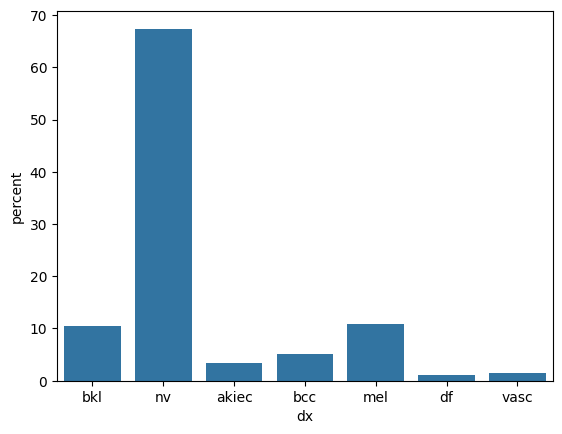

In [26]:
sns.countplot(Train, x="dx", stat="percent")

In [27]:
def Augmentation(dat, apply_dx):
  new_data = pd.DataFrame()
  rotations = [
      iaa.Affine(rotate=90),
      iaa.Affine(rotate=180),
      iaa.Affine(rotate=270)
      ]
  for index, line in dat.iterrows():
    if(line['dx']!='nv'):
      image_np = np.array(line['Image'])
      augmented_images = [(rotation(image=image_np)) for rotation in rotations]
      for aug_image in augmented_images:
        new_line = line.copy()
        new_line['Image'] = Image.fromarray(aug_image)
        new_data = pd.concat([new_data, new_line.to_frame().T], ignore_index=True)
  return new_data

In [28]:
Aug_Data=Augmentation(Train, 'apply_dx')
Aug_Data

,lesion_id,image_id,dx,dx_type,age,sex,localization,Image
0,HAM_0005146,ISIC_0030346,bkl,histo,60.0,male,face,<PIL.Image.Image image mode=RGB size=64x64 at ...
1,HAM_0005146,ISIC_0030346,bkl,histo,60.0,male,face,<PIL.Image.Image image mode=RGB size=64x64 at ...
2,HAM_0005146,ISIC_0030346,bkl,histo,60.0,male,face,<PIL.Image.Image image mode=RGB size=64x64 at ...
3,HAM_0006085,ISIC_0033322,bkl,histo,85.0,female,face,<PIL.Image.Image image mode=RGB size=64x64 at ...
4,HAM_0006085,ISIC_0033322,bkl,histo,85.0,female,face,<PIL.Image.Image image mode=RGB size=64x64 at ...
...,...,...,...,...,...,...,...,...
5872,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,<PIL.Image.Image image mode=RGB size=64x64 at ...
5873,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,<PIL.Image.Image image mode=RGB size=64x64 at ...
5874,HAM_0003435,ISIC_0031350,mel,histo,60.0,male,back,<PIL.Image.Image image mode=RGB size=64x64 at ...
5875,HAM_0003435,ISIC_0031350,mel,histo,60.0,male,back,<PIL.Image.Image image mode=RGB size=64x64 at ...


In [29]:
Train=pd.concat([Train, Aug_Data], ignore_index=True)
Train

,lesion_id,image_id,dx,dx_type,age,sex,localization,Image
0,HAM_0005146,ISIC_0030346,bkl,histo,60.0,male,face,"[[[100, 86, 127], [104, 97, 133], [103, 97, 13..."
1,HAM_0007477,ISIC_0032007,nv,histo,25.0,male,back,"[[[201, 201, 231], [207, 207, 231], [208, 209,..."
2,HAM_0007071,ISIC_0030449,nv,follow_up,35.0,female,trunk,"[[[169, 158, 235], [165, 154, 235], [172, 154,..."
3,HAM_0001767,ISIC_0025812,nv,histo,50.0,female,lower extremity,"[[[165, 145, 164], [168, 146, 165], [165, 142,..."
4,HAM_0003907,ISIC_0027587,nv,follow_up,60.0,male,upper extremity,"[[[144, 127, 218], [141, 125, 219], [126, 111,..."
...,...,...,...,...,...,...,...,...
11881,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,<PIL.Image.Image image mode=RGB size=64x64 at ...
11882,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,<PIL.Image.Image image mode=RGB size=64x64 at ...
11883,HAM_0003435,ISIC_0031350,mel,histo,60.0,male,back,<PIL.Image.Image image mode=RGB size=64x64 at ...
11884,HAM_0003435,ISIC_0031350,mel,histo,60.0,male,back,<PIL.Image.Image image mode=RGB size=64x64 at ...


<Axes: xlabel='dx', ylabel='percent'>

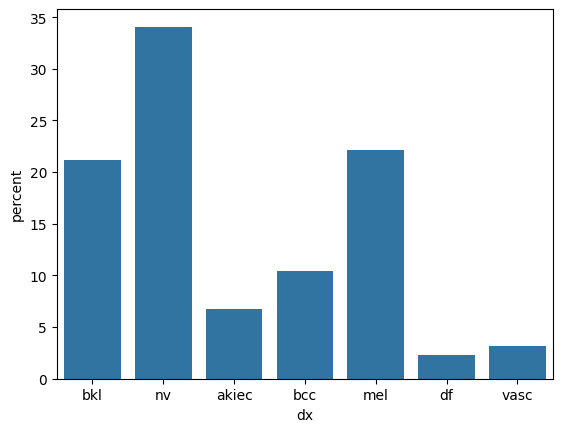

In [30]:
sns.countplot(Train, x="dx", stat="percent")

Run the following code to normalize the dataset and learn about its shapes:

### Сборка данных

In [32]:
def prepare_data(images):
    m = len(images)
    print(m)
    X = np.zeros((m, height, width, chanels), dtype=np.uint8)
    for i, image_file in enumerate(images):
        X[i,:] = image_file
    return X

In [33]:
X_train = prepare_data(Train['Image'])/255.
X_test = prepare_data(Test['Image'])/255.
X_val = prepare_data(Val['Image'])/255.

11886
2003
2003


In [34]:
class_labels = {
    'akiec': 0,
    'bcc': 1,
    'bkl': 2,
    'df': 3,
    'nv': 4,
    'vasc': 5,
    'mel': 6
}
Y_train = to_categorical(Train['dx'].replace(class_labels), num_classes=num_classes)
Y_test = to_categorical(Test['dx'].replace(class_labels), num_classes=num_classes)
Y_val = to_categorical(Val['dx'].replace(class_labels), num_classes=num_classes)

<ipython-input-34-eb22b42d0357>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_train = to_categorical(Train['dx'].replace(class_labels), num_classes=num_classes)
<ipython-input-34-eb22b42d0357>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_test = to_categorical(Test['dx'].replace(class_labels), num_classes=num_classes)
<ipython-input-34-eb22b42d0357>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_object

In [35]:
A_test = (Test['age']/85.).to_numpy().reshape(-1, 1)
A_train = (Train['age']/85.).to_numpy().reshape(-1, 1)
A_val = (Val['age']/85.).to_numpy().reshape(-1, 1)

In [36]:

print ("number of training examples =", X_train.shape[0])
print ("number of test examples =", X_test.shape[0])
print ("X_train shape:", X_train.shape)
print ("Y_train shape:", Y_train.shape)
print ("A_train shape:", A_train.shape)
print ("X_test shape:", X_test.shape)
print ("Y_test shape:", Y_test.shape)
print ("A_test shape:", A_test.shape)
print ("X_val shape:", X_val.shape)
print ("Y_val shape:", Y_val.shape)
print ("A_val shape:", A_val.shape)

number of training examples = 11886
number of test examples = 2003
X_train shape: (11886, 64, 64, 3)
Y_train shape: (11886, 7)
A_train shape: (11886, 1)
X_test shape: (2003, 64, 64, 3)
Y_test shape: (2003, 7)
A_test shape: (2003, 1)
X_val shape: (2003, 64, 64, 3)
Y_val shape: (2003, 7)
A_val shape: (2003, 1)


In [37]:
np.isnan(A_train).any()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [38]:
data['age'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 10015 entries, 0 to 10014
Series name: age
Non-Null Count  Dtype  
--------------  -----  
10015 non-null  float64
dtypes: float64(1)
memory usage: 78.4 KB


## Модель

In [39]:
def resnet_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, shortcut])  # Добавляем вход (shortcut)
    x = layers.ReLU()(x)
    return x

def create_model(input_shape, num_classes, num_additional_features):
    inputs = layers.Input(shape=input_shape)

    # Начальный слой
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Блоки ResNet
    for _ in range(3):  # Меньше блоков для ускорения
        x = resnet_block(x, 32)

    # Глобальное усреднение
    x = layers.GlobalAveragePooling2D()(x)

    # Объединение с дополнительными признаками
    additional_inputs = layers.Input(shape=(num_additional_features,))
    combined = layers.concatenate([x, additional_inputs])

    # Полносвязный слой
    combined = layers.Dense(64, activation='relu')(combined)
    outputs = layers.Dense(num_classes, activation='softmax')(combined)

    model = models.Model(inputs=[inputs, additional_inputs], outputs=outputs)
    return model

In [41]:
%matplotlib inline
def plot_history(loss, val_loss, accuracy, val_accuracy):
    # График потерь
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='val_accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [42]:
class ShowHistory(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []

    def on_epoch_end(self, epoch, logs={}):
        # Сохраняем значения потерь и точности
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracies.append(logs.get('accuracy'))
        self.val_accuracies.append(logs.get('val_accuracy'))

        if (epoch + 1) % 5 == 0:  # Каждые 10 эпох
            plot_history(self.losses, self.val_losses, self.accuracies, self.val_accuracies)

In [52]:
model = create_model(input_shape, num_classes, num_additional_features)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 # Обучение модели
history = model.fit(
    [X_test, A_test],
    Y_test,
    epochs=100,  # Увеличьте количество эпох для демонстрации
    batch_size=128,
    validation_data=([X_val, A_val], Y_val)
    #callbacks=[ShowHistory()]
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 491ms/step - accuracy: 0.3700 - loss: 1.7407 - val_accuracy: 0.6575 - val_loss: 1.5850
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.6695 - loss: 0.9846 - val_accuracy: 0.6575 - val_loss: 1.5043
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.6562 - loss: 0.9170 - val_accuracy: 0.6575 - val_loss: 1.5103
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.6778 - loss: 0.8869 - val_accuracy: 0.6570 - val_loss: 1.5056
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.6878 - loss: 0.8637 - val_accuracy: 0.6036 - val_loss: 1.5281
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.6853 - loss: 0.8379 - val_accuracy: 0.4948 - val_loss: 1.6156
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.6991 - loss: 0.8153 - val_accuracy: 0.6490 - val_loss: 1.4295
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.6904 - loss: 0.8214 - val_acc

In [53]:
from sklearn.metrics import precision_score, recall_score, f1_score

preds = model.evaluate([X_test, A_test], Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

# Прогнозирование на тестовых данных
Y_pred = model.predict([X_test, A_test])
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

# Вычисление дополнительных метрик
precision = precision_score(Y_true_classes, Y_pred_classes, average='weighted')
recall = recall_score(Y_true_classes, Y_pred_classes, average='weighted')
f1 = f1_score(Y_true_classes, Y_pred_classes, average='weighted')

print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F1 Score = " + str(f1))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7835 - loss: 0.6116
Loss = 0.5716814994812012
Test Accuracy = 0.7913130521774292
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Precision = 0.7772987469213546
Recall = 0.7913130304543186
F1 Score = 0.7652284359610443


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [54]:
preds = model.evaluate([X_test, A_test], Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7835 - loss: 0.6116
Loss = 0.5716814994812012
Test Accuracy = 0.7913130521774292


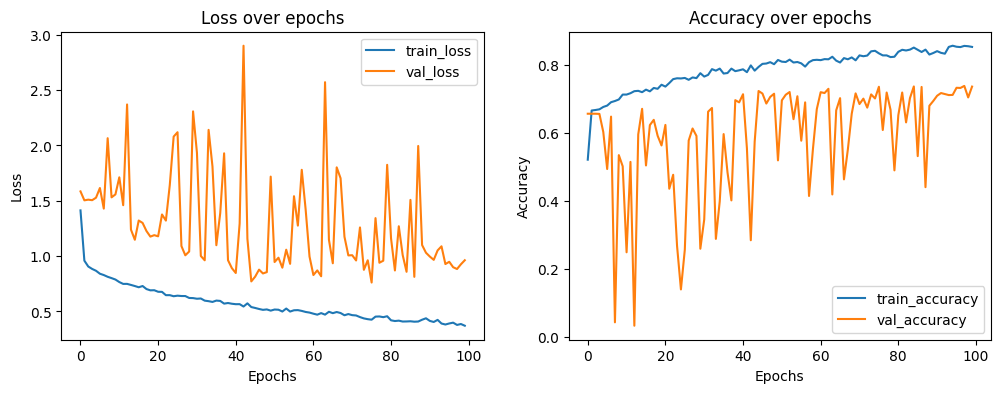

In [55]:
# Вызов функции для построения графиков
plot_history(history.history['loss'],history.history['val_loss'],history.history['accuracy'],history.history['val_accuracy'])

In [49]:
%matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Потери обучения')
plt.plot(epochs, val_loss, 'g', label='Потери валидации')
plt.title('Потери обучения и валидации')
plt.xlabel('Эпохи') # Полная итерация алгоритма над обучающим набором данных.
plt.ylabel('Потери')
plt.legend()
plt.show()

AttributeError: module 'matplotlib' has no attribute 'plot'

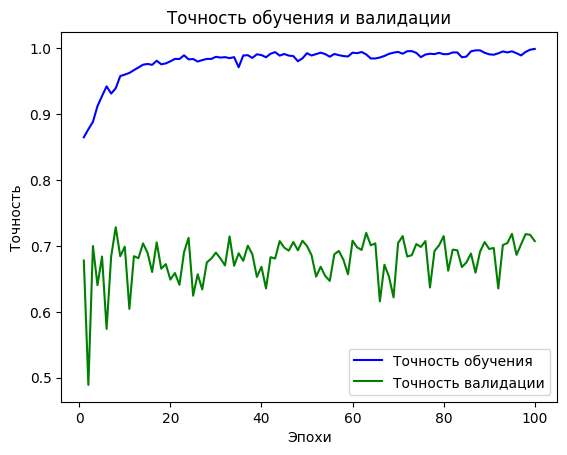

In [ ]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Точность обучения')
plt.plot(epochs, val_loss, 'g', label='Точность валидации')
plt.title('Точность обучения и валидации')
plt.xlabel('Эпохи') # Полная итерация алгоритма над обучающим набором данных.
plt.ylabel('Точность')
plt.legend()
plt.show()

In [23]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 64, 64, 32)     │            896 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 64, 64, 32)     │            128 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_14 (ReLU)           │ (None, 64, 64, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 64, 64, 32)     │          9,248 │ re_lu_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 64, 64, 32)     │            128 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_15 (ReLU)           │ (None, 64, 64, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 64, 64, 32)     │          9,248 │ re_lu_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 64, 64, 32)     │            128 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 64, 64, 32)     │              0 │ batch_normalization_1… │
│                           │                        │                │ re_lu_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_16 (ReLU)           │ (None, 64, 64, 32)     │              0 │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 64, 64, 32)     │          9,248 │ re_lu_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 64, 64, 32)     │            128 │ conv2d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_17 (ReLU)           │ (None, 64, 64, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 64, 64, 32)     │          9,248 │ re_lu_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 64, 64, 32)     │            128 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 178,839 (698.59 KB)

 Trainable params: 59,463 (232.28 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 118,928 (464.57 KB)

In [7]:
%matplotlib notebook
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib_inline

x = np.linspace(0, 10, 100)
y = np.cos(x)

plt.ion()

figure, ax = plt.subplots(figsize=(8, 6))
(line1,) = ax.plot(x, y)

plt.title("Dynamic Plot of sinx", fontsize=25)

plt.xlabel("X", fontsize=18)
plt.ylabel("sinX", fontsize=18)

for p in range(100):
    updated_y = np.cos(x - 0.05 * p)

    line1.set_xdata(x)
    line1.set_ydata(updated_y)

    figure.canvas.draw()

    figure.canvas.flush_events()
    time.sleep(0.1)

<IPython.core.display.Javascript object>